In [1]:
import os
import random

import matplotlib.pyplot as plt
import mlflow
import numpy
import seaborn
from sklearn.cluster import SpectralClustering
import torch
from torch.utils.data import TensorDataset

from eval_utils import get_clustering_error, post_process_coefficient_matrix
from models.sscn import SscnLinear

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/root/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Dump results into default location
mlflow.set_tracking_uri('../mlflow')

## Load toy dataset

In [4]:
loaded = numpy.load('../data/toy/data.npz')

x_train = loaded['x_train']
y_train = loaded['y_train']

x_test = loaded['x_test']
y_test = loaded['y_test']

x_train_tensor = torch.FloatTensor(x_train)
y_train_tensor = torch.LongTensor(y_train)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

x_test_tensor = torch.FloatTensor(x_test)
y_test_tensor = torch.LongTensor(y_test)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

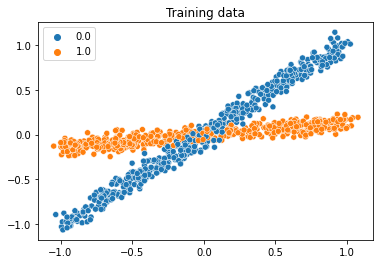

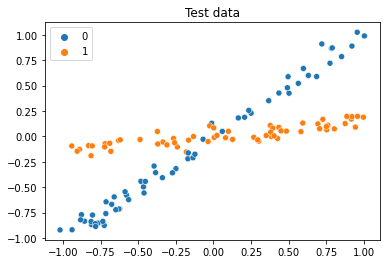

In [5]:
%matplotlib inline

fig, ax = plt.subplots(1)
seaborn.scatterplot(x=x_train[:, 0], 
                    y=x_train[:, 1], 
                    hue=y_train,
                    ax=ax,
                   )
ax.set_title('Training data')
plt.show()

fig, ax = plt.subplots(1)
seaborn.scatterplot(x=x_test[:, 0], 
                    y=x_test[:, 1], 
                    hue=y_test,
                    ax=ax,
                   )
ax.set_title('Test data')
plt.show()

## Train linear SSCN model

In [6]:
seed = 0
device = 0

num_features = 2
num_clusters = 2
max_cluster_dim = 1
lambda_reg = 1.
lambda_ssc = 1.
lambda_assignment = 1.
se_bias = False

num_epochs = 30
learning_rate = 1e-2
batch_size = 64
shuffle_batches = True

noise_threshold = 0.1
noise_alpha = 8.

num_epochs_classifier = 30
num_iterations_per_batch_classifier = 10
learning_rate_classifier = 1e-1
batch_size_classifier = 64
shuffle_batches_classifier = True
use_pseudo_labels = False
pos_thres = 0.9
neg_thres = 0.1
margin = 0.1

In [7]:
# Fix random seed
random.seed(seed)
numpy.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize model
model = SscnLinear(num_features=num_features,
                   num_clusters=num_clusters,
                   max_cluster_dim=max_cluster_dim,
                   lambda_reg=lambda_reg,
                   lambda_ssc=lambda_ssc,
                   lambda_assignment=lambda_assignment,
                   se_bias=se_bias,
                  )

# Move to device
torch.cuda.set_device(device)
model = model.to('cuda')

In [8]:
model.train_se(dataset=train_dataset,
               num_epochs=num_epochs,
               learning_rate=learning_rate,
               batch_size=batch_size,
               shuffle_batches=shuffle_batches,
              )

## Cluster training data by computing and clustering the self-expression affinity matrix

In [9]:
H_train_tensor = model.se_encoder(x_train_tensor.to('cuda')).detach()
Q_train_tensor = H_train_tensor @ H_train_tensor.T
A_s_train_tensor = model.get_self_expression_affinities(Q_train_tensor)

H_train = H_train_tensor.cpu().numpy()
Q_train = Q_train_tensor.cpu().numpy()
A_s_train = A_s_train_tensor.cpu().numpy()

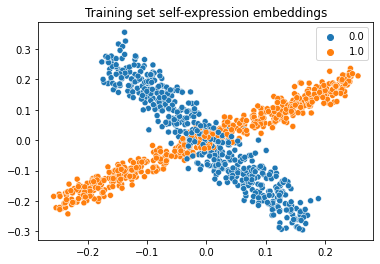

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1)
seaborn.scatterplot(x=H_train[:, 0], 
                    y=H_train[:, 1], 
                    hue=y_train,
                    ax=ax,
                   )
ax.set_title('Training set self-expression embeddings')
plt.show()

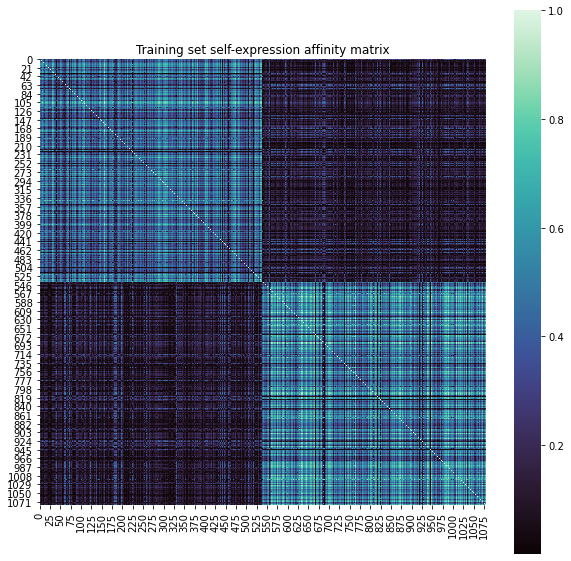

In [11]:
def plot_coefficient_matrix(matrix, 
                            labels,
                            ax,
                           ):
    labels_sorted = numpy.argsort(labels)
    matrix_sorted = numpy.copy(matrix)
    matrix_sorted = matrix_sorted[labels_sorted, :][:, labels_sorted]
    seaborn.heatmap(matrix_sorted, 
                    ax=ax, 
                    cmap='mako', 
                    square=True,
                   )
    
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(10, 10))
plot_coefficient_matrix(matrix=A_s_train, 
                        labels=y_train, 
                        ax=ax,
                       )
ax.set_title('Training set self-expression affinity matrix')
plt.show()

In [12]:
spectral = SpectralClustering(n_clusters=num_clusters,
                              eigen_solver='arpack',
                              affinity='precomputed',
                              assign_labels='discretize',
                              n_jobs=-1,
                             )
y_pred_train_spectral = spectral.fit_predict(A_s_train)

acc_train_spectral = 1. - get_clustering_error(y_train, y_pred_train_spectral)
print('Spectral clustering accuracy on training set: {:.2f}%'.format(acc_train_spectral * 100))

Spectral clustering accuracy on training set: 93.89%


## Train geometric classifier using triplet loss

In [13]:
model.train_classifier(dataset=train_dataset,
                       num_epochs=num_epochs_classifier,
                       num_iterations_per_batch=num_iterations_per_batch_classifier,
                       learning_rate=learning_rate_classifier,
                       batch_size=batch_size_classifier,
                       shuffle_batches=shuffle_batches_classifier,
                       use_pseudo_labels=use_pseudo_labels,
                       pos_thres=pos_thres,
                       neg_thres=neg_thres,
                       margin=margin,
                      )

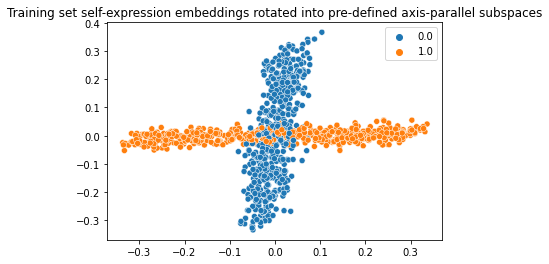

In [14]:
H_train_rotated_tensor = (H_train_tensor @ model.classifier.R).detach()
H_train_rotated = H_train_rotated_tensor.cpu().numpy()

%matplotlib inline
fig, ax = plt.subplots(1)
seaborn.scatterplot(x=H_train_rotated[:, 0], 
                    y=H_train_rotated[:, 1], 
                    hue=y_train,
                    ax=ax,
                   )
ax.set_title('Training set self-expression embeddings rotated into pre-defined axis-parallel subspaces')
plt.show()

In [15]:
y_pred_train = model.get_cluster_assignments(dataset=train_dataset,
                                             method='classifier',
                                            )

acc_train = 1. - get_clustering_error(y_train, y_pred_train)
print('Classification accuracy on training set: {:.2f}%'.format(acc_train * 100))

Classification accuracy on training set: 93.80%


## Evaluate classifier on separate test set

In [16]:
y_pred_test = model.get_cluster_assignments(dataset=test_dataset,
                                            method='classifier',
                                           )

acc_test = 1. - get_clustering_error(y_test, y_pred_test)
print('Classification accuracy on test set: {:.2f}%'.format(acc_test * 100))

Classification accuracy on test set: 96.67%


## Compute closed-form solution for verification

In [17]:
# Compute reduced SVD
U, Sigma, Vt = numpy.linalg.svd(x_train.T, 
                                full_matrices=False,
                               )

# Compute optimal self-expression embedding function
num_hidden_se = num_clusters * max_cluster_dim
W_opt = numpy.sqrt(lambda_ssc * (numpy.eye(num_hidden_se) 
                                 - lambda_ssc * numpy.linalg.inv(numpy.power(Sigma, -2.) 
                                                                 + lambda_ssc * numpy.eye(num_hidden_se)
                                                                )
                                )
                  ) * U.T

# Compute optimal coefficient matrix
Q_train_opt = x_train @ W_opt @ W_opt.T @ x_train.T

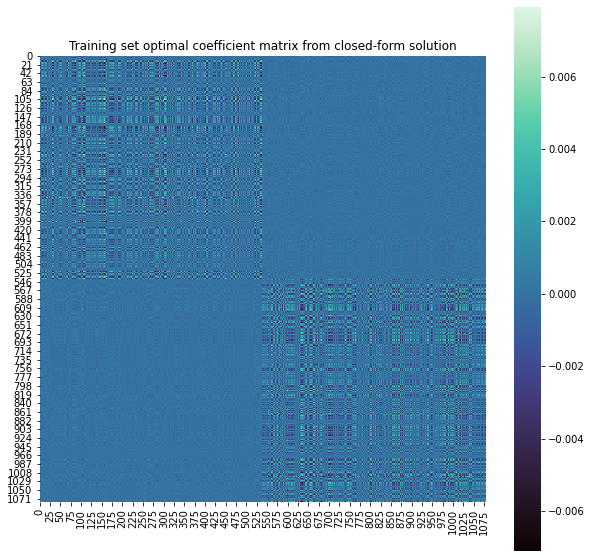

In [18]:
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(10, 10))
plot_coefficient_matrix(matrix=Q_train_opt, 
                        labels=y_train, 
                        ax=ax,
                       )
ax.set_title('Training set optimal coefficient matrix from closed-form solution')
plt.show()